In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from __init__ import *

utils.rng.set_seed()
device = utils.gpu.set_devices(3)

In [3]:
tf = transforms.Compose([
    transforms.CenterCrop((384, 384)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

# Import data
train = datasets.get_coco(transform=tf)
test = datasets.get_coco(transform=tf, train=False)

reshape = nn.AvgPool2d(4)

# Get data parameters
N = len(train)
M = 384 * 384
Q = 96 * 96


# Set training parameters and loader
batch_size = 32
epochs = 8
nu = 0.0005
loader = torch.utils.data.DataLoader(
    train, batch_size=batch_size, shuffle=True, pin_memory=True
)

# Initialize experiment dictionaries
loss_trace = {}
nets = {}
opts = {}

# Set experiment name
experiment_name = 'ie_dense_superres_patch'

In [4]:
# TODO: Test with other patch dimensions for better results?
# patch_dims =    [2304, 1024, 576, 256,    9]
# grid_dims_pie = [  64,  144, 256, 576, 1024]

patch_dims =     [256, 256, 256, 256, 256]
grid_dims_pie =  [576, 484, 361, 196,  36]
grid_dims_ae  =  [576, 225, 144,  64,  36]

model_kwargs = {
    'activation': modules.BiCELU,
    'activation_params': {},
    'device': device,
}

nets = {
    "IEL": models.dense.AdjointDenseMixer(
        patch_dims,
        grid_dims_pie,
        diagonal=True,
        type='lie',        
        **model_kwargs,
    ),
    "IEC": models.dense.AdjointDenseMixer(
        patch_dims,
        grid_dims_pie,
        diagonal=True,
        type='cayley',        
        **model_kwargs,
    ),
}

for k, model in nets.items():
    loss_trace[k] = {}
    opts[k] = torch.optim.Adam(model.parameters() , lr=nu)


# Generate winsplit
split = modules.AdjointSequential(
    modules.AdjointPatchSplitter((24,24), (16,16)),
    modules.AdjointFlatten(-2, -1, (24,24))
)

splitsmall = modules.AdjointSequential(
    modules.AdjointPatchSplitter((6,6), (16,16)),
    modules.AdjointFlatten(-2, -1, (6,6))
)

In [5]:
# Define objective function

def objective_function(x, xh, y, yh, params=None, l2_lambda=1e-6, reduction='mean'):
    losses = {}
    
    if params is not None:
        losses['l2'] = torch.tensor(0.).to(x.device)
        for param in params:
            losses['l2'] += torch.norm(param)
        losses['l2'] *= l2_lambda
    
    kwargs = {'reduction': reduction}    
    kwargs['alpha'] = 5.0

    losses['lx'] = utils.loss.logcosh(xh, x, **kwargs)
    losses['ly'] = utils.loss.logcosh(yh, y, **kwargs)
#     losses['ls'] = 0.1 * utils.loss.logcosh(
#         splitsmall.T(yh) - reshape(split.T(x)), 
#         splitsmall.T(y) - reshape(split.T(xh)), 
#         **kwargs
#     )
    losses['l'] = sum(losses.values())
    return losses['l'], losses

In [6]:
# Print no. parameters
print("Number of Parameters:")
for k in nets.keys():
    print(f"No. params {k:8}:  {utils.metrics.no_parameters(nets[k])}")

Number of Parameters:
No. params IEL     :  1069628
No. params IEC     :  1069628


In [7]:
# Set examples for training, testing and visualization
sample_indices_small = np.array([0, 3, 42, 85, 666, 1001, 6969, 31415])

# Convert sample indices to tensors
xims = torch.cat([train[k] for k in sample_indices_small])
ys = splitsmall(reshape(xims)).to(device)
xs = split(xims).to(device)


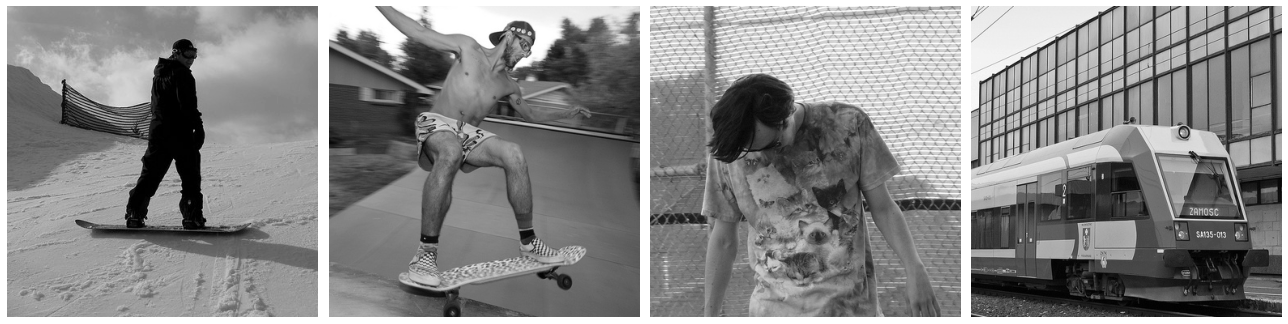

In [8]:
fig, ax = plt.subplots(1, 4, figsize=(18,8))
for i in range(4):
    ax[i].imshow(xims[i], cmap='gray')

for a in ax:
    a.grid(False)
    a.axis('off')

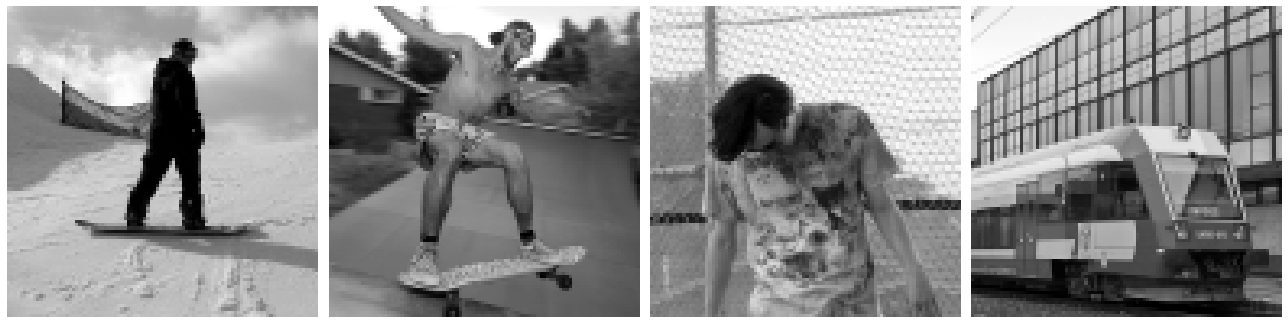

In [9]:
fig, ax = plt.subplots(1, 4, figsize=(18,8))
for i in range(4):
    ax[i].imshow(reshape(xims[i][None,...])[0], cmap='gray')

for a in ax:
    a.grid(False)
    a.axis('off')

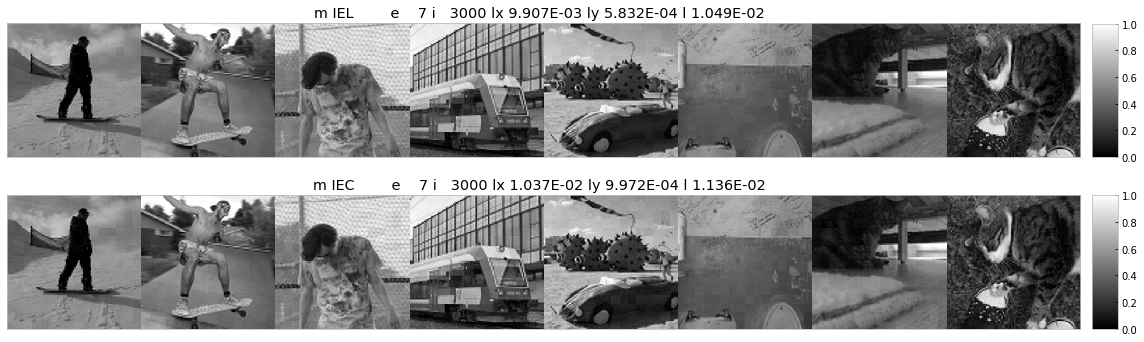

In [10]:
# Training loop

for e in range(epochs):
    i = 0
    for x in loader:
        y = splitsmall(reshape(x.to(device))).detach()
        x = split(x.to(device))
                
        xhs = {}
        ldicts = {}
        for m, cur in enumerate(nets):
            # Reset gradients and do forward pass
            opts[cur].zero_grad()            
            yh = nets[cur](x)
            xh = nets[cur].T(y)

            # Calculate loss
            loss, ldicts[cur] = objective_function(x, xh, y, yh)

            loss.backward()
            opts[cur].step()
            
            # Reporting
            for k, v in ldicts[cur].items():
                
                if k not in loss_trace[cur]:
                    loss_trace[cur][k] = []

                loss_trace[cur][k].append(v)


        # Plot and Report
        if i % 25 == 0:
            for cur in nets.keys():
                with torch.no_grad():
                    xhs[cur] = split.T(
                        nets[cur].T(ys)
                    ).cpu()
            clear_output(wait=True)
            utils.reporting.plot_training(xhs, e, i, ldicts, path=experiment_name, save=(i % 50 == 0), cmap='gray')
            
        i += 1

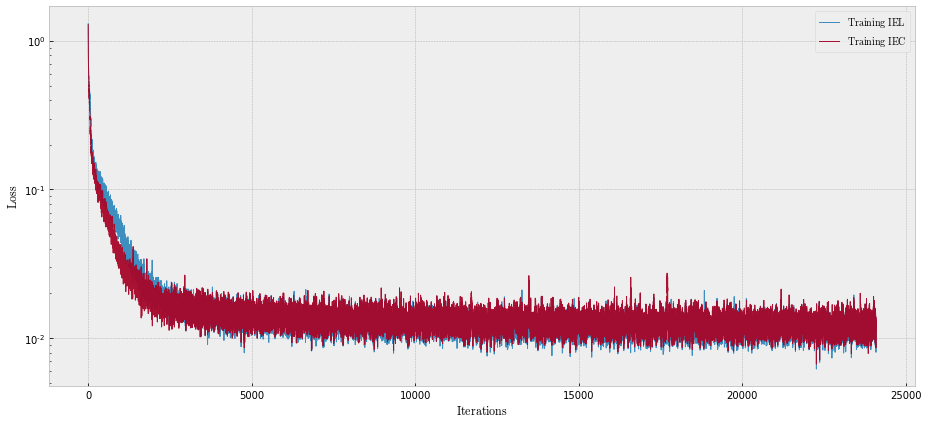

In [12]:
# Convert trace to numpy
np_loss_trace = {}
for k in loss_trace:
    np_loss_trace[k] = {}
    for l in loss_trace[k]:
        np_loss_trace[k][l] = np.array([v.item() for v in loss_trace[k][l]])

# Plot overall loss
for k in nets.keys():
    plt.plot(np_loss_trace[k]["l"], linewidth=1, label=f"$\mathrm{{Training\,\,{k}}}$", alpha=0.95)

plt.legend()
plt.xlabel('$\mathrm{Iterations}$')
plt.ylabel('$\mathrm{Loss}$')
#plt.ylim(0.005, 0.05)
plt.yscale("log")
plt.savefig(f'../figures/training/{experiment_name}.pdf')

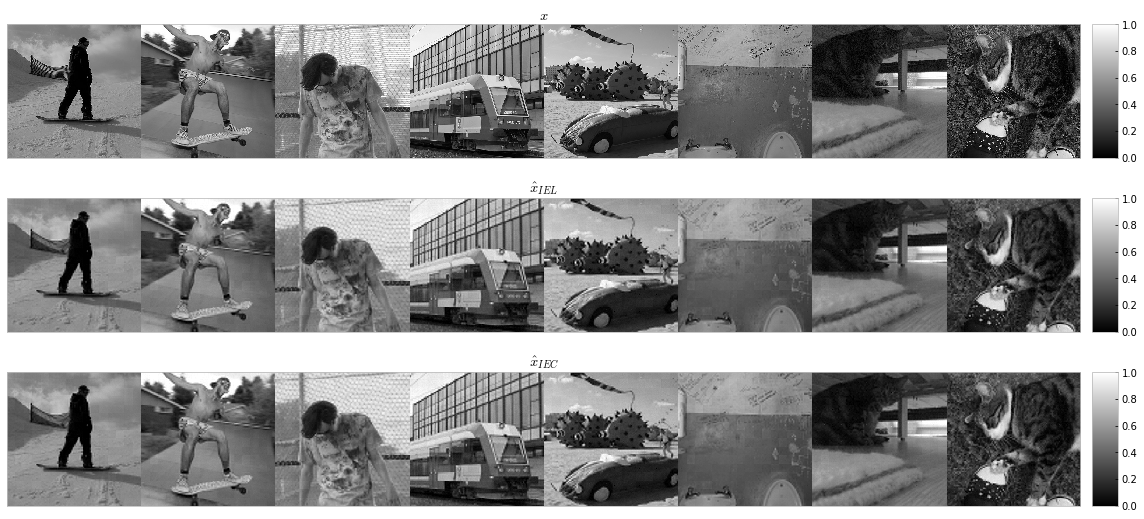

In [13]:
# Move models to CPU
for cur, model in nets.items():
    nets[cur] = model.to(device)
    
# Plot results
with torch.no_grad():
    xhs = {"": xims}
    
    for k in nets.keys():
        xhs[k] = split.T(nets[cur].T(ys)).cpu()
    
utils.reporting.plot_results(xhs, '', fname=experiment_name, cmap='gray')

In [14]:
example = 6888

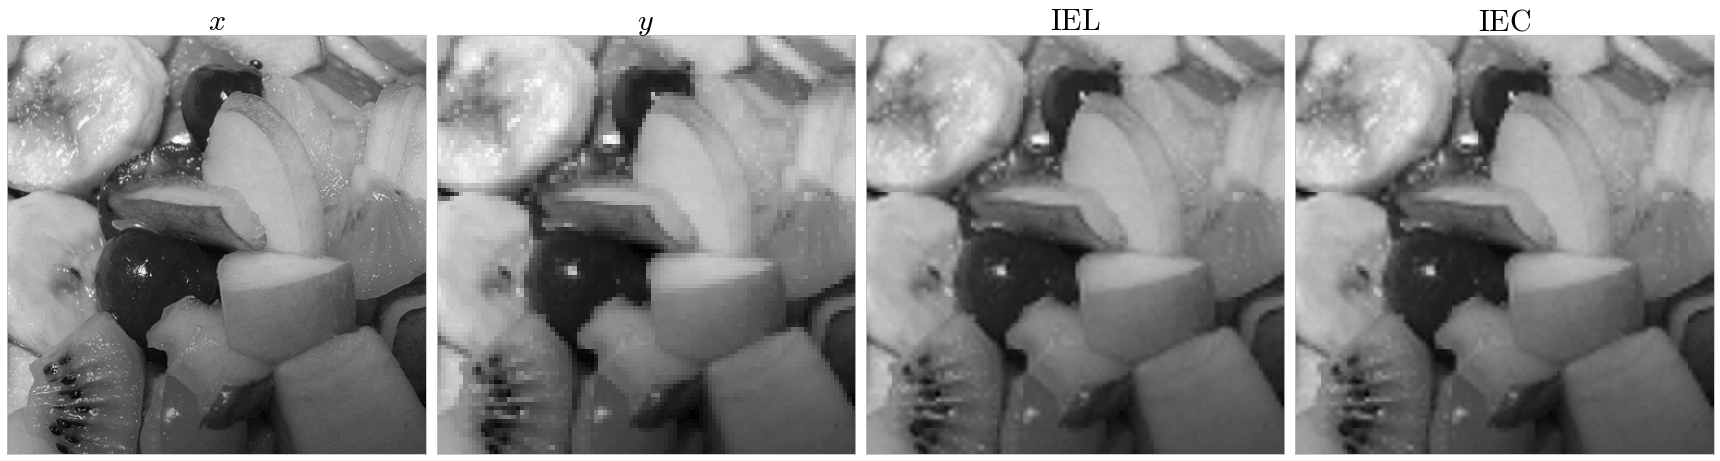

In [18]:
fig, ax = plt.subplots(1, 4, figsize=(24,10))

ax[0].imshow(train[example][0], cmap='gray')
ax[0].set_title('$x$', fontsize=30)
ax[1].imshow(reshape(train[example])[0], cmap='gray')
ax[1].set_title('$y$', fontsize=30)


for i, cur in enumerate(nets):
    with torch.no_grad():
        xh = nets[cur].T(
            nets[cur](
                split(train[example]).to(device)
            )
        )

    ax[i+2].imshow(
        split.T(xh).cpu()[0],
        cmap='gray'
    )
    ax[i+2].set_title(f'$\mathrm{{{cur}}}$', fontsize=30)
    
for a in ax.flatten():
    a.grid(False)
    a.tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)

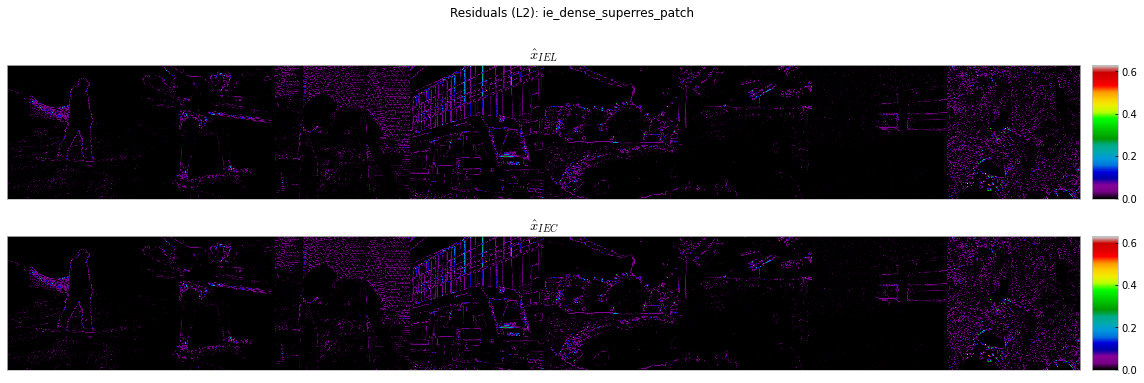

In [19]:
# Plot residuals (L2)
with torch.no_grad():
    xhs = {}
    curmax = 0

    for k in nets.keys():
        xhs[k] = split.T(nets[cur].T(ys)).cpu()
        xhs[k] = (xhs[k] - xims)**2
        if torch.max(xhs[k]) > curmax:
            curmax = torch.max(xhs[k])

utils.reporting.plot_results(
    xhs, f'Residuals (L2): {experiment_name}', vmax=curmax, fname=experiment_name + 'res', root='../figures/results/'
)

In [20]:
# Move models to CPU
for cur, model in nets.items():
    nets[cur] = model.to('cpu')
    del model
    
torch.cuda.empty_cache()

In [21]:
# Save models

serialized_path = f'../serialized/experiments/{experiment_name}/'
if not os.path.isdir(serialized_path):
    os.mkdir(serialized_path)

for name, model in nets.items():
    with open(f'{serialized_path}{name}.pt', 'wb') as outfile:
        torch.save(model, outfile)

In [22]:
# Save training results

with open(f'{serialized_path}training.pickle', 'wb') as outfile:
    pickle.dump(np_loss_trace, outfile)

In [10]:
# Load models

serialized_path = f'../serialized/experiments/{experiment_name}/'
nets = {'IEL': None, 'IEC': None}
for m in nets:
    with open(f'{serialized_path}{m}.pt', 'rb') as outfile:
        nets[m] = torch.load(outfile)

In [11]:
# Compute test tensor

test_tensor = []
for i in tqdm(range(len(test))):
    test_tensor.append(test[i])
    
test_tensor = split(torch.cat(test_tensor))

  0%|          | 0/4002 [00:00<?, ?it/s]

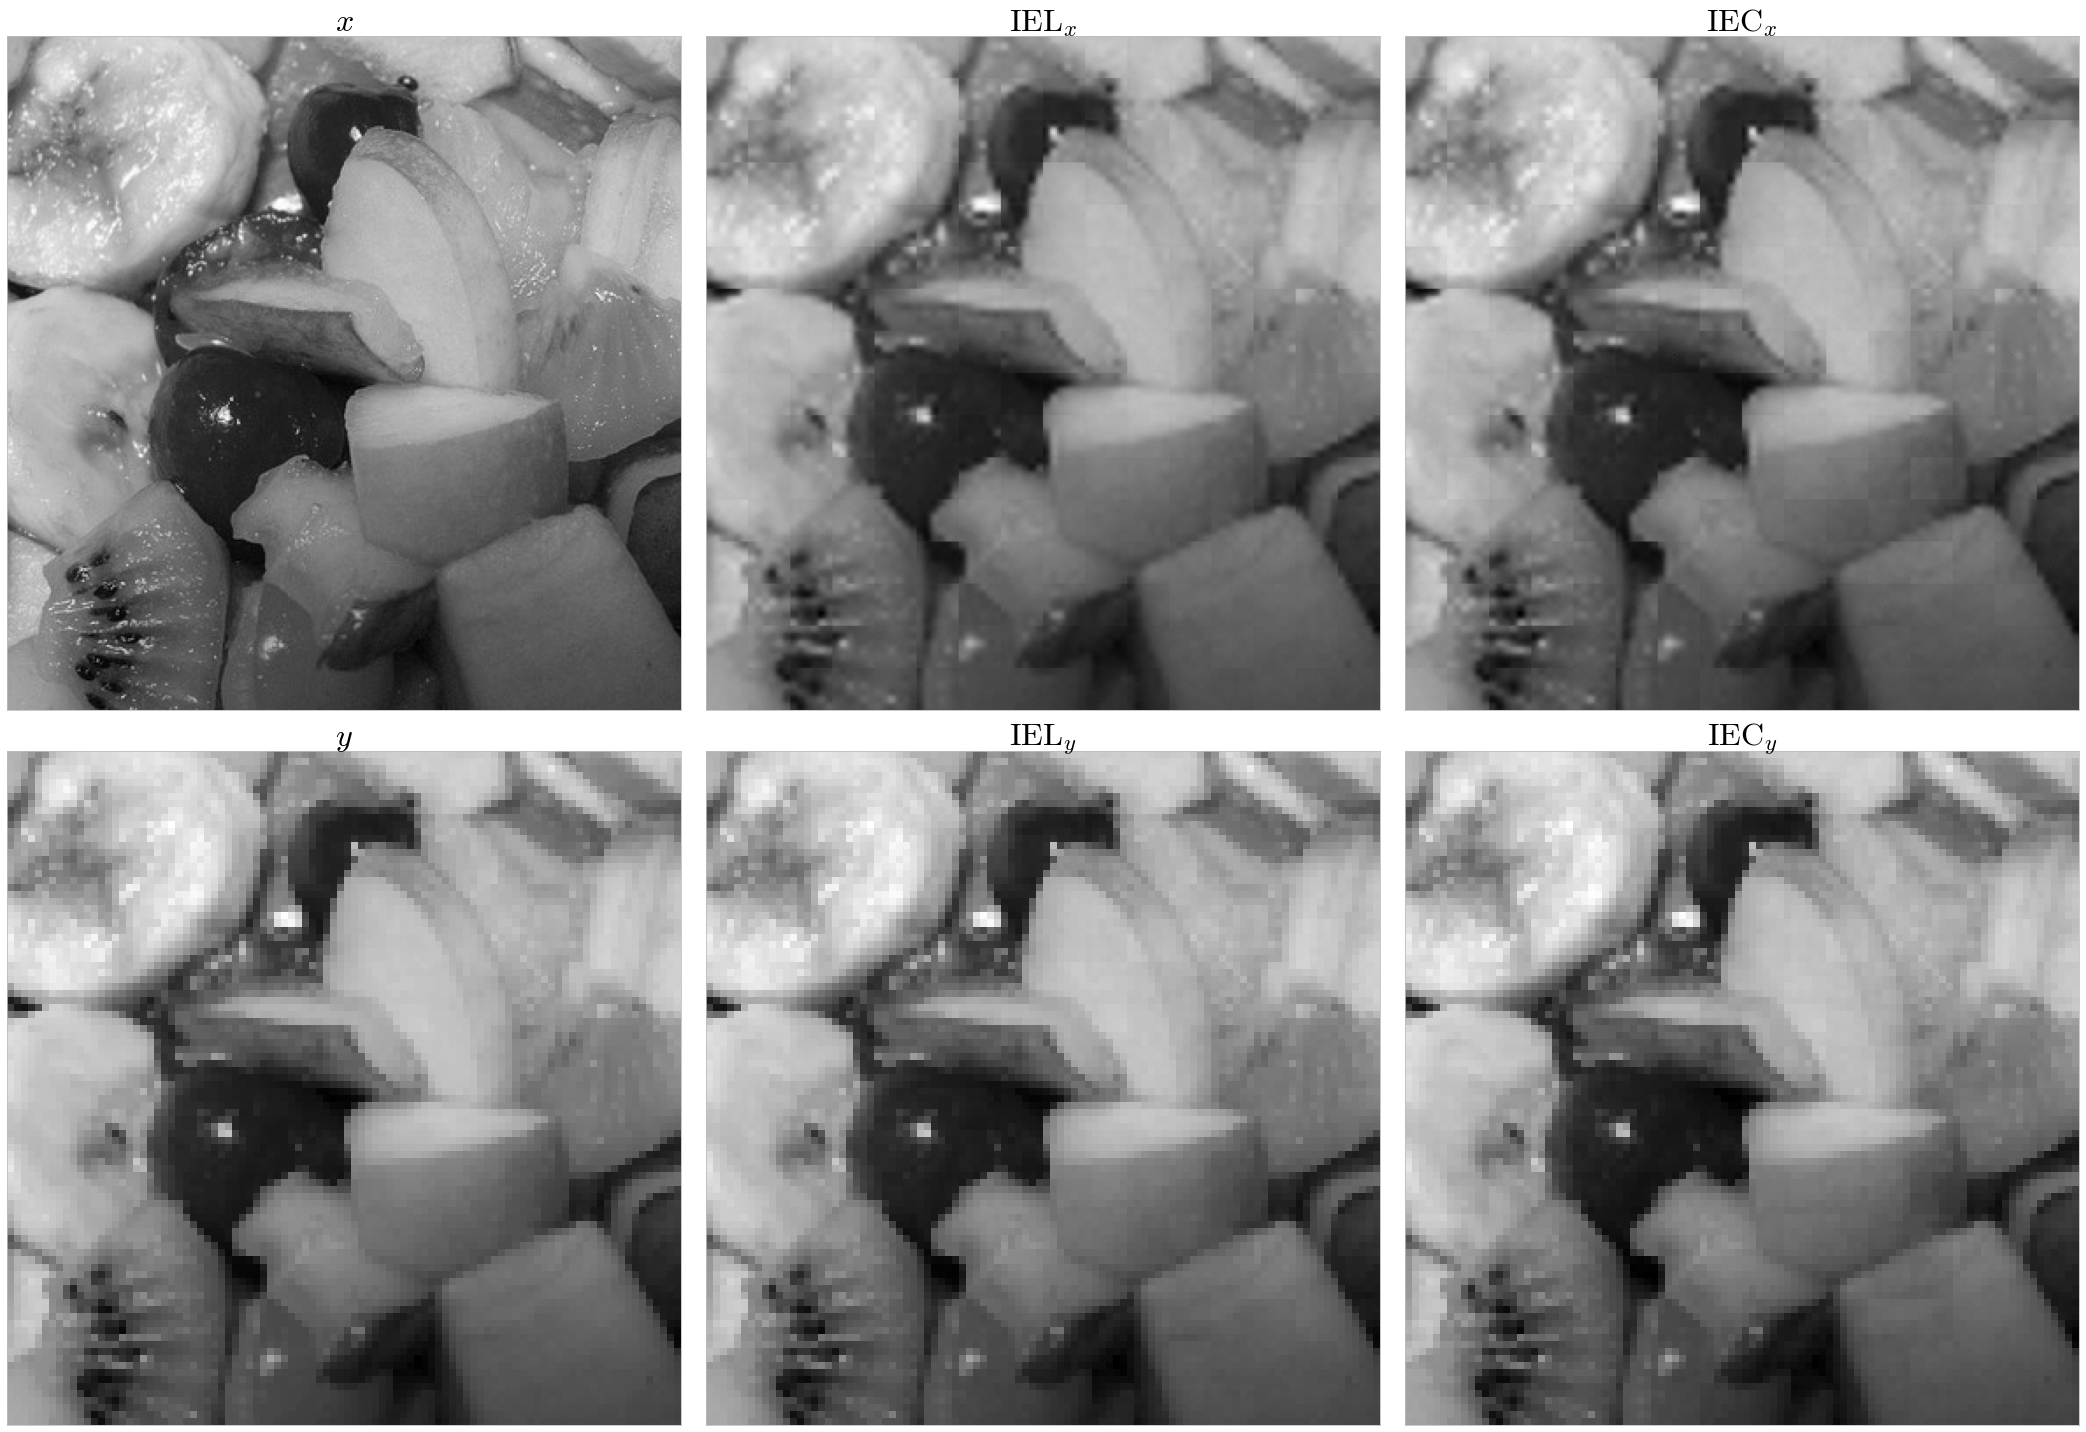

In [12]:
example = 6888
fig, ax = plt.subplots(2, 3, figsize=(30,20))

ax[0,0].imshow(train[example][0], cmap='gray')
ax[0,0].set_title('$x$', fontsize=32)
ax[1,0].imshow(reshape(train[example])[0], cmap='gray')
ax[1,0].set_title('$y$', fontsize=32)


for i, cur in enumerate(nets):
    with torch.no_grad():
        yh = nets[cur](split(train[example]))
        xh = nets[cur].T(splitsmall(reshape(train[example])))

    ax[0,i+1].imshow(
        split.T(xh).cpu()[0],
        cmap='gray'
    )
    ax[0,i+1].set_title(f'$\mathrm{{{cur}}}_x$', fontsize=32)
    
    ax[1,i+1].imshow(
        splitsmall.T(yh).cpu()[0],
        cmap='gray'
    )
    ax[1,i+1].set_title(f'$\mathrm{{{cur}}}_y$', fontsize=32)
    
for a in ax.flatten():
    a.grid(False)
    a.tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)
    
plt.savefig(f'../figures/results/{experiment_name}_fruit.pdf')

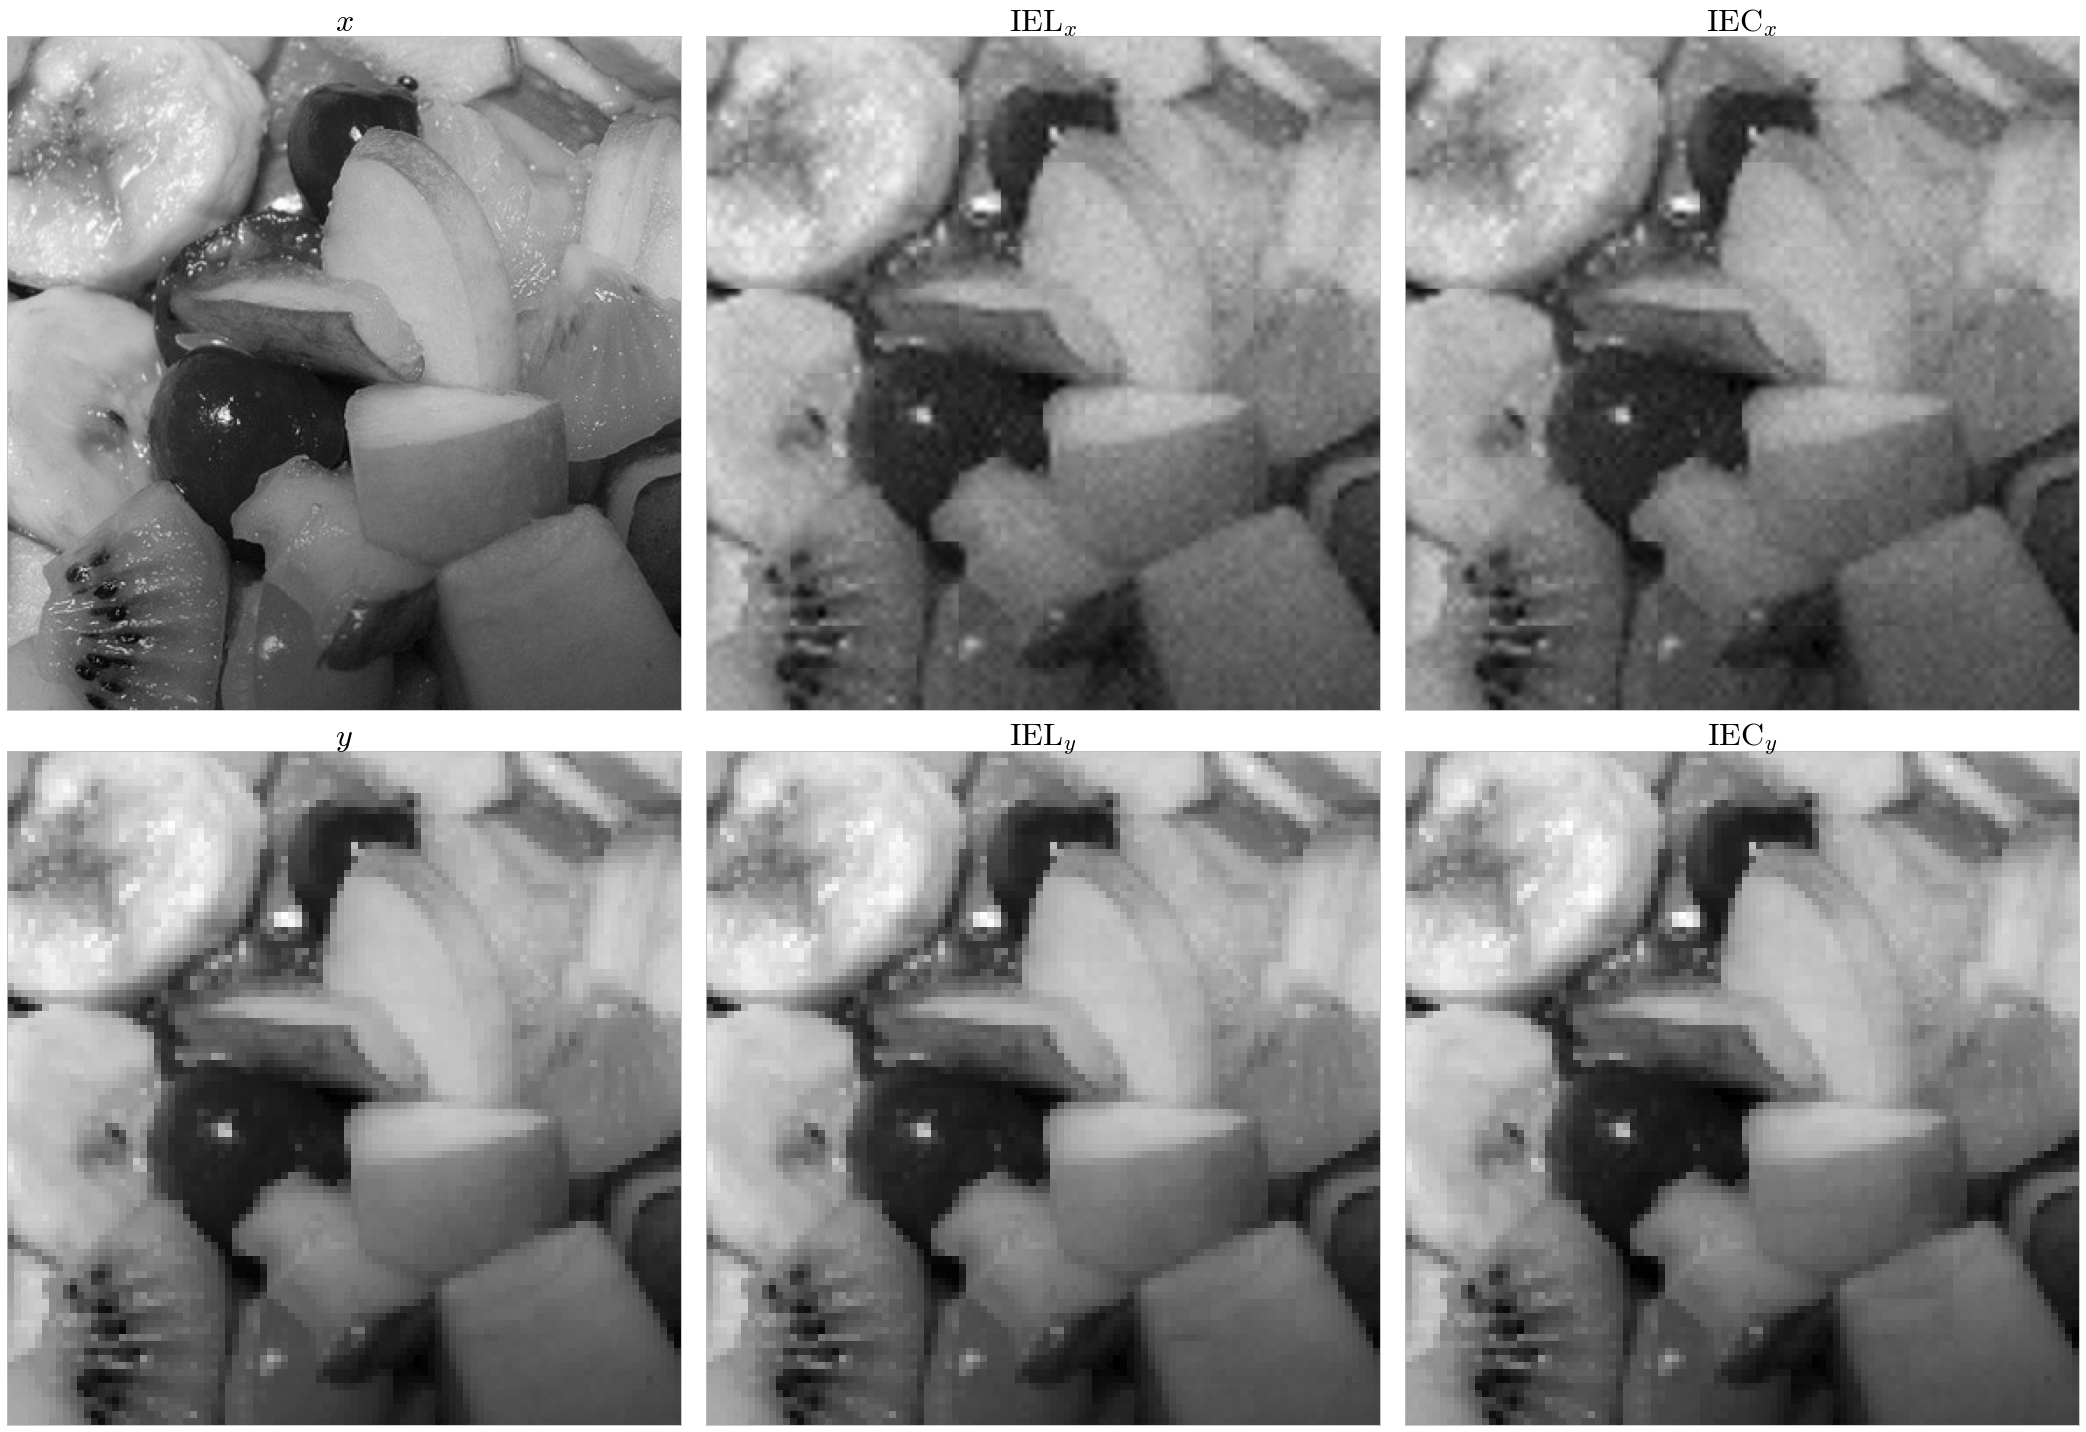

In [13]:
fig, ax = plt.subplots(2, 3, figsize=(30,20))

ax[0,0].imshow(train[example][0], cmap='gray')
ax[0,0].set_title('$x$', fontsize=32)
ax[1,0].imshow(reshape(train[example])[0], cmap='gray')
ax[1,0].set_title('$y$', fontsize=32)


for i, cur in enumerate(nets):
    with torch.no_grad():
        yh = nets[cur](split(train[example]))
        noise = torch.randn(1, 96, 96) * 0.015
        xh = nets[cur].T(splitsmall(reshape(train[example]) + noise))

    ax[0,i+1].imshow(
        split.T(xh).cpu()[0],
        cmap='gray'
    )
    ax[0,i+1].set_title(f'$\mathrm{{{cur}}}_x$', fontsize=32)
    
    ax[1,i+1].imshow(
        splitsmall.T(yh).cpu()[0],
        cmap='gray'
    )
    ax[1,i+1].set_title(f'$\mathrm{{{cur}}}_y$', fontsize=32)
    
for a in ax.flatten():
    a.grid(False)
    a.tick_params(bottom=False, left=False, labelleft=False, labelbottom=False)
    
plt.savefig(f'../figures/results/{experiment_name}_fruit_noise.pdf')

In [14]:
# Calculate relative error on test data

print(f"Relative Error:")
for k, model in nets.items():
    with torch.no_grad():
        xth = model.T(splitsmall(reshape(split.T(test_tensor))))
    print(
        f"{k:6}: " + 
        f"RE {utils.metrics.relative_error(split.T(xth).flatten(-2, -1), split.T(test_tensor).flatten(-2, -1), reduction='mean'):4E} " +
        f"MSE {F.mse_loss(split.T(xth).flatten(-2, -1), split.T(test_tensor).flatten(-2, -1), reduction='mean'):4E} "
    )

Relative Error:
IEL   : RE 1.410330E-01 MSE 5.445560E-03 
IEC   : RE 1.425915E-01 MSE 5.548937E-03 


In [15]:
del xth
import gc
gc.collect();

In [16]:
# Calculate relative error on test data

print(f"Relative Error:")
for k, model in nets.items():
    with torch.no_grad():
        yth = model(test_tensor)
    print(
        f"{k:6}: " + 
        f"RE {utils.metrics.relative_error(yth.flatten(-2, -1), splitsmall(reshape(split.T(test_tensor))).flatten(-2, -1), reduction='mean'):4E} " +
        f"MSE {F.mse_loss(yth.flatten(-2, -1), splitsmall(reshape(split.T(test_tensor))).flatten(-2, -1), reduction='mean'):4E} "
    )

Relative Error:
IEL   : RE 2.310329E-02 MSE 1.551324E-04 
IEC   : RE 2.963545E-02 MSE 2.411666E-04 


In [17]:
del yth
gc.collect();

In [18]:
print('IEL', (2.310329E-02 + 1.410330E-01)/2)
print('IEC', (1.425915E-01 + 2.963545E-02)/2)

IEL 0.082068145
IEC 0.08611347500000001


In [19]:
# Calculate PSNR and SSIM on test data
print(f"Image Reconstruction Metrics:")
for k, model in nets.items():
    with torch.no_grad():
        XH = model.T(splitsmall(reshape(split.T(test_tensor))))
        dothings = lambda x: split.T(x).flatten(-2, -1)
        psnr = utils.metrics.psnr(dothings(test_tensor), dothings(XH))
        ssim = utils.metrics.ssim(
            split.T(test_tensor)[:,None,...], 
            split.T(XH)[:,None,...]
        )
    print(
        f"{k:6}: " + 
        f"PSNR {psnr:4E} " +
        f"SSIM {ssim:4E} "
    )

# Clear memory
del XH
gc.collect();

Image Reconstruction Metrics:
IEL   : PSNR 2.263958E+01 SSIM 6.602741E-01 
IEC   : PSNR 2.255790E+01 SSIM 6.489866E-01 


In [20]:
# Calculate PSNR and SSIM on test data
print(f"Image Reconstruction Metrics:")
for k, model in nets.items():
    with torch.no_grad():
        YH = model(test_tensor)
        dothings = lambda x: splitsmall(reshape(split.T(x)))
        psnr = utils.metrics.psnr(dothings(test_tensor).flatten(-2, -1), YH.flatten(-2, -1))
        ssim = utils.metrics.ssim(
            dothings(test_tensor)[:,None,...], 
            YH[:,None,...]
        )
    print(
        f"{k:6}: " + 
        f"PSNR {psnr:4E} " +
        f"SSIM {ssim:4E} "
    )

# Clear memory
del YH
gc.collect();

Image Reconstruction Metrics:
IEL   : PSNR 3.809297E+01 SSIM 9.907538E-01 
IEC   : PSNR 3.617683E+01 SSIM 9.861942E-01 


In [21]:
print('IEL', (2.263958E+01 + 3.809297E+01)/2)
print('IEC', (2.255790E+01 + 3.617683E+01)/2)

IEL 30.366275
IEC 29.367365


In [22]:
# Move models to GPU
for k in nets:
    nets[k] = nets[k].to(device)

utils.rng.set_seed(42)

# Estimate Condition Number using Adverserial Perturbation
rs = {}
opts_p = {}
epochs = 3
loss_trace_p = {}
for k in nets.keys():
    loss_trace_p[k] = {'l': [], 'lphi': []}
    rs[k] = nn.Parameter(torch.randn(256, 576).to(device))
    _zs = torch.sum(rs[k] == 0)
    while _zs > 0:
        rs[k][rs[k] == 0] = nn.Parameter(torch.random.randn(_zs))
        _zs = torch.sum(rs[k] == 0)
    nets[k].eval()
    opts_p[k] = torch.optim.Adam([rs[k]])

In [23]:
# Define Perturbation Objective
def perturbation_objective(xe, xh, ye, yh):
    losses = {}
    
    lphix = -F.mse_loss(xe, xh)
    lphiy = -F.mse_loss(xe, xh)
    losses['lphix'] = lphix
    losses['lphiy'] = lphiy

    return sum(losses.values()), losses

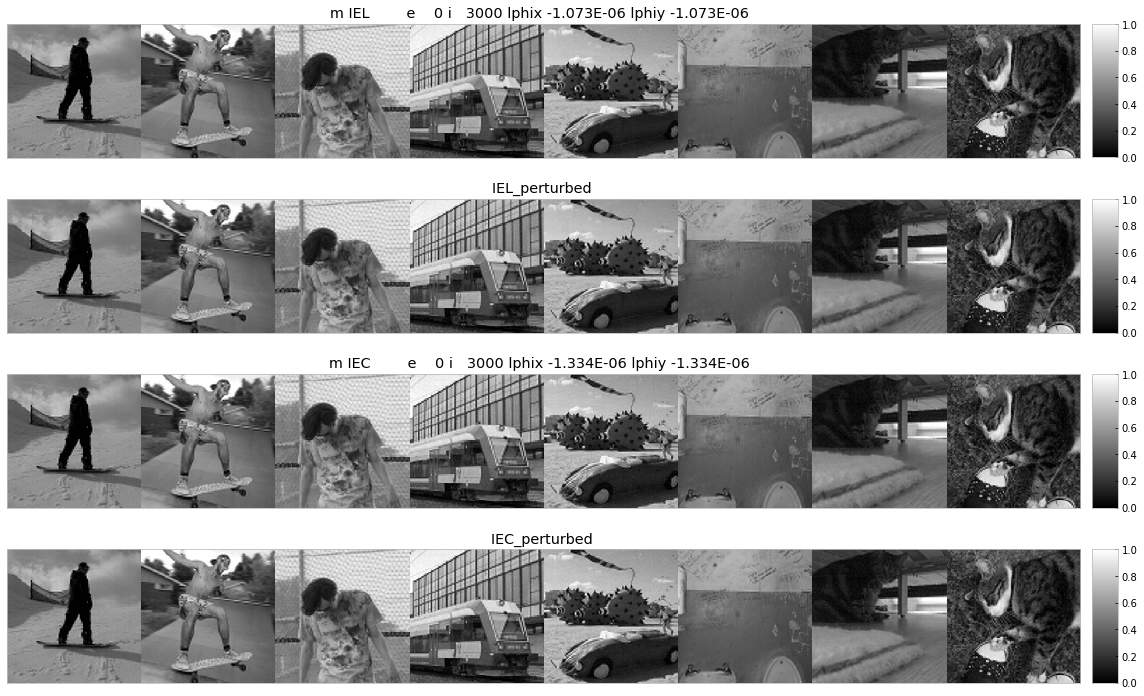

In [24]:
# Training loop

for e in range(1):
    i = 0
    for x in loader:
        y = splitsmall(reshape(x.to(device))).detach()
        x = split(x.to(device))
        xhs = {}
        ldicts = {}
        for m, cur in enumerate(nets):
            # Reset gradients and do forward pass
            opts_p[cur].zero_grad()
            r = utils.projection.project_into_ball(rs[cur].flatten(-2, -1), 1, 2).unflatten(-1, (256, 576))

            yh = nets[cur](x)
            ye = nets[cur](x + r)
            xh = nets[cur].T(yh)
            xe = nets[cur].T(ye)

            # Calculate loss
            loss, ldicts[cur] = perturbation_objective(xe, xh, yh, ye)

            loss.backward()
            opts_p[cur].step()
            
            # Reporting
            for k, v in ldicts[cur].items():
                
                if k not in loss_trace_p[cur]:
                    loss_trace_p[cur][k] = []

                loss_trace_p[cur][k].append(v)


        # Plot and Report
        if i % 15 == 0:
            for cur in nets.keys():
                with torch.no_grad():
                    per = f'{cur}_perturbed'
                    r = utils.projection.project_into_ball(rs[cur].flatten(-2, -1), 1, 2).unflatten(-1, (256, 576))

                    xhs[cur] = split.T(nets[cur].T(nets[cur](xs))).cpu()
                    xhs[per] = split.T(nets[cur].T(nets[cur](xs + r))).cpu()
            clear_output(wait=True)
            utils.reporting.plot_training(xhs, e, i, ldicts, save=False, cmap='gray')            
        i += 1

In [25]:
for cur, model in nets.items():
    nets[cur] = model.to('cpu')

print(f"Relative Cond:")

for k, model in nets.items():
    with torch.no_grad():
        r = utils.projection.project_into_ball(rs[k].flatten(-2, -1).cpu(), 1, 2).unflatten(-1, (256, 576))
        XE = model.T(model(test_tensor + r))
        XH = model.T(model(test_tensor))

    rerr_psi = utils.metrics.relative_error(XH.flatten(-2,-1), XE.flatten(-2,-1), reduction='mean')
    rerr_x = utils.metrics.relative_error(test_tensor.flatten(-2,-1), (test_tensor + r).flatten(-2,-1), reduction='mean')
    cond_no = utils.metrics.relative_cond_no(XH.flatten(-2,-1), XE.flatten(-2,-1), test_tensor.flatten(-2,-1), r.flatten(-2,-1), reduction='mean')
    
    print(f"{k:6}: {rerr_psi.item():2.6f} {rerr_x.item():2.6f} {cond_no.item():2.6f}")

Relative Cond:
IEL   : 0.002169 0.005357 0.071817
IEC   : 0.002402 0.005357 0.079545


In [27]:
# Save state dict

serialized_path = f'../serialized/experiments/{experiment_name}/'
if not os.path.isdir(serialized_path):
    os.mkdir(serialized_path)

for k in nets:
    torch.save(nets[k].state_dict(), serialized_path + k + '.ptsd')

In [12]:
# Move models to GPU
for k in nets:
    nets[k] = nets[k].to(device)

utils.rng.set_seed(42)

# Estimate Condition Number using Adverserial Perturbation
rs = {}
opts_p = {}
epochs = 3
loss_trace_p = {}
for k in nets.keys():
    loss_trace_p[k] = {'l': [], 'lphi': []}
    rs[k] = nn.Parameter(torch.randn(256, 36).to(device))
    _zs = torch.sum(rs[k] == 0)
    while _zs > 0:
        rs[k][rs[k] == 0] = nn.Parameter(torch.random.randn(_zs))
        _zs = torch.sum(rs[k] == 0)
    nets[k].eval()
    opts_p[k] = torch.optim.Adam([rs[k]])

In [13]:
# Define Perturbation Objective
def perturbation_objective(xe, xh):
    losses = {}
    
    lphix = -F.mse_loss(xe, xh)
    losses['lphix'] = lphix

    return sum(losses.values()), losses

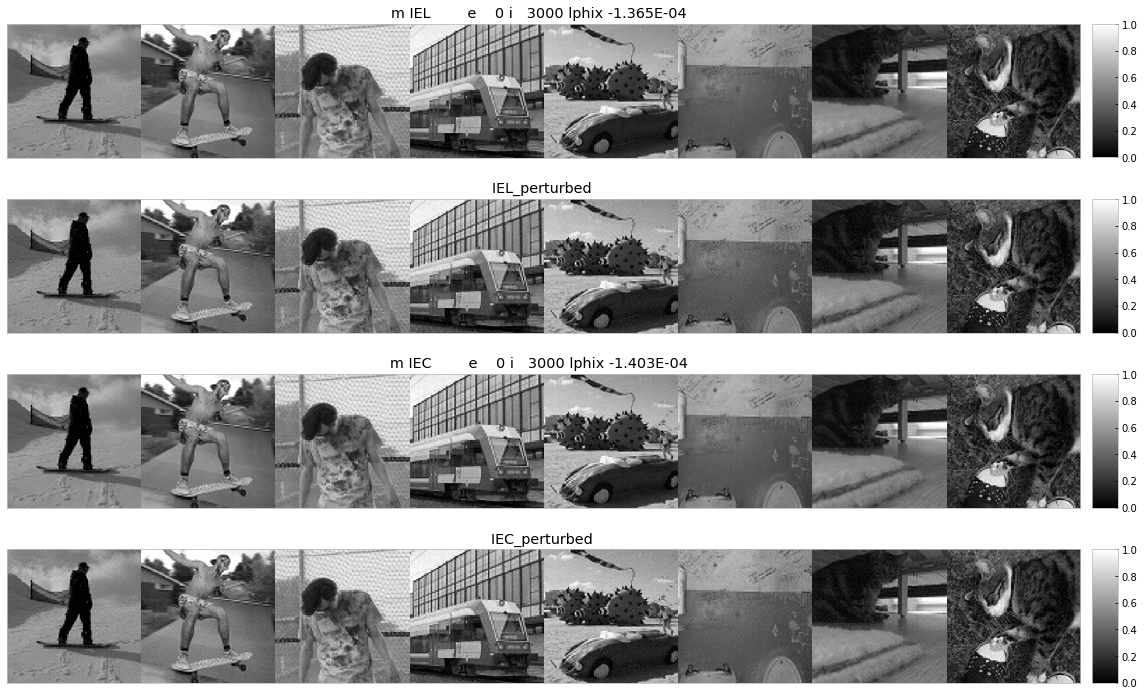

In [16]:
# Training loop

for e in range(1):
    i = 0
    for x in loader:
        y = splitsmall(reshape(x.to(device))).detach()
        x = split(x.to(device))
        xhs = {}
        ldicts = {}
        for m, cur in enumerate(nets):
            # Reset gradients and do forward pass
            opts_p[cur].zero_grad()
            r = utils.projection.project_into_ball(rs[cur].flatten(-2, -1), 1, 2).unflatten(-1, (256, 36))

            xh = nets[cur].T(y)
            xe = nets[cur].T(y + r)

            # Calculate loss
            loss, ldicts[cur] = perturbation_objective(xe, xh)

            loss.backward()
            opts_p[cur].step()
            
            # Reporting
            for k, v in ldicts[cur].items():
                
                if k not in loss_trace_p[cur]:
                    loss_trace_p[cur][k] = []

                loss_trace_p[cur][k].append(v)


        # Plot and Report
        if i % 15 == 0:
            for cur in nets.keys():
                with torch.no_grad():
                    per = f'{cur}_perturbed'
                    r = utils.projection.project_into_ball(rs[cur].flatten(-2, -1), 1, 2).unflatten(-1, (256, 36))

                    xhs[cur] = split.T(nets[cur].T(nets[cur](xs))).cpu()
                    xhs[per] = split.T(nets[cur].T(nets[cur](xs) + r)).cpu()
            clear_output(wait=True)
            utils.reporting.plot_training(xhs, e, i, ldicts, save=False, cmap='gray')            
        i += 1

In [19]:
for cur, model in nets.items():
    nets[cur] = model.to('cpu')

print(f"Relative Cond:")
yt = splitsmall(reshape(split.T(test_tensor))).detach()
for k, model in nets.items():
    with torch.no_grad():
        r = utils.projection.project_into_ball(rs[cur].flatten(-2, -1), 1, 2).unflatten(-1, (256, 36)).cpu()
        XH = model.T(yt)
        XE = model.T(yt + r)

    cond_no = utils.metrics.relative_cond_no(XH.flatten(-2,-1), XE.flatten(-2,-1), yt.flatten(-2,-1), r.flatten(-2,-1), reduction='mean')
    
    print(f"{k:6}: {cond_no.item():2.6f}")

Relative Cond:
IEL   : 0.792814
IEC   : 0.803226
